# <u>**Exploratory Data Analysis**

## **Summary and Key Take-Aways:**

* ✅ **Individual Signal Morphology:** Distinct P-wave, QRS complex and T-wave visible; each sample contains ≥1 heartbeat.
* ✅ **Signal Precision:** Original data at 16-decimal granularity; rounding to 2 decimals is sufficient for expert labeling.
* ✅ **Class Imbalance:**

  * MIT-BIH: Normal beats dominate, especially Class 1 and 3 are underrepresented
  * PTBDB: Pathological signals outnumber normals \~2∶1
    ⇒ Requires over/undersampling or class-weight strategies.
* ✅ **Signal Correlation:**

  * MIT-BIH train vs. test: similar beat-type distributions
  * PTBDB normal vs. abnormal: clear ST-segment shifts tied to pathology
* ✅ **Averaged Signals & Information Loss:**

  * Averaged signals preserve only the initial incomplete QRS and T-wave
  * Preprocessing spikes (column 1) and zero-fills distort true ECG morphology
    ⇒ Mean waveforms lack diagnostic detail.
* ✅ **Normality Violation:**

  * PTBDB: 0 % of columns normal
  * MIT-BIH train: 0.21 %; test: 1.06 % normal
*  ➤➤ **Next Steps:** Leverage these insights to develop advanced preprocessing pipelines that retain critical ECG features and enhance model interpretability.


## **1. The Individual Signals:** 

### **Data Loading and Preparation:**

In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# MIT-BIH Dataset
mitbih_test_df = pd.read_csv("mitbih_test.csv")
mitbih_train_df = pd.read_csv("mitbih_train.csv")
# Renaming the columns
new_column_names = range(1, len(mitbih_train_df.columns) + 1)
mitbih_train_df.columns = new_column_names
new_column_names = range(1, len(mitbih_test_df.columns) + 1)
mitbih_test_df.columns = new_column_names
# Transforming the Target Variable to Integer
mitbih_train_df[188]=mitbih_train_df[188].astype(int)
mitbih_test_df[188]=mitbih_test_df[188].astype(int)

# PTBDB Dataset
ptbdb_abnormal_df = pd.read_csv("ptbdb_abnormal.csv")
ptbdb_normal_df = pd.read_csv("ptbdb_normal.csv")
# Renaming the columns
new_column_names = range(1, len(ptbdb_normal_df.columns) + 1)
ptbdb_normal_df.columns = new_column_names
new_column_names = range(1, len(ptbdb_abnormal_df.columns) + 1)
ptbdb_abnormal_df.columns = new_column_names
# Combining the two Dataframes 
ptbdb_comb_df = pd.concat([ptbdb_normal_df, ptbdb_abnormal_df], ignore_index=True)
# Transforming the Target Variable to Integer
ptbdb_comb_df[188]=ptbdb_comb_df[188].astype(int)

### **The Datasets and Classes:**

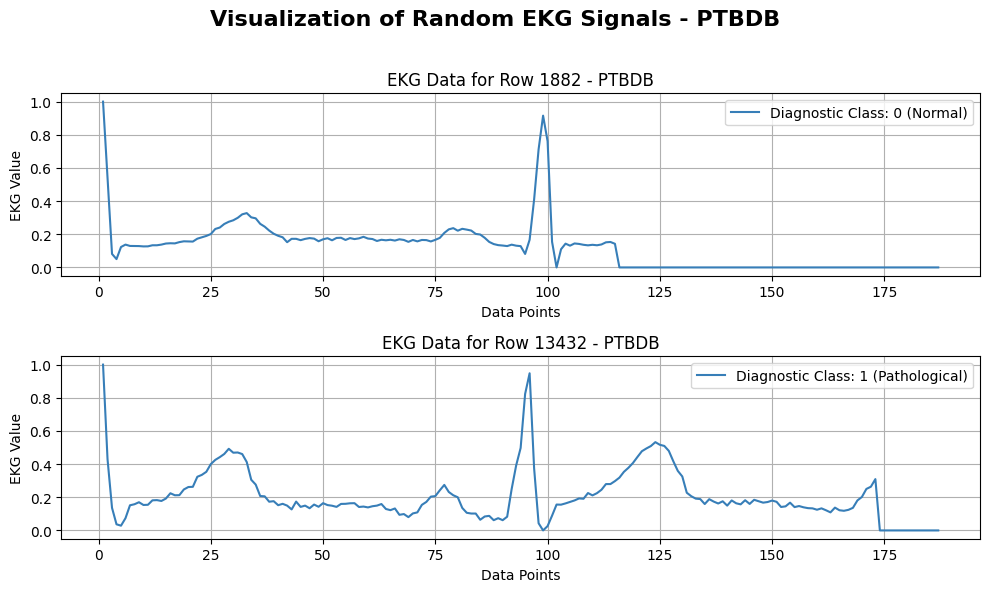

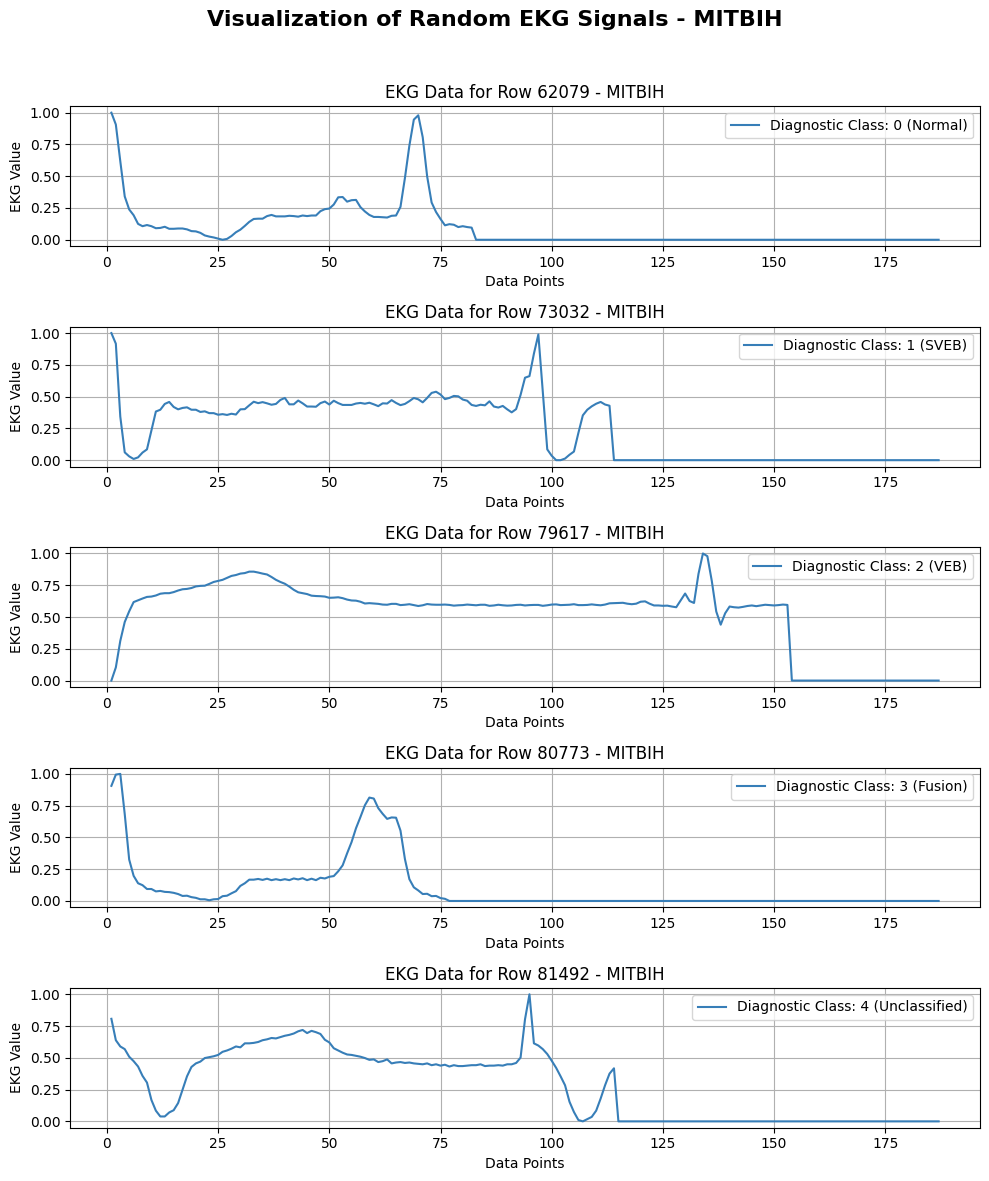

In [29]:
import random

# Define diagnostic class names
ptbdb_class_names = {0: "Normal", 1: "Pathological"}
mitbih_class_names = {
    0: "Normal",
    1: "SVEB",
    2: "VEB",
    3: "Fusion",
    4: "Unclassified",
}

# PTBDB Visualization: Random Signal from Each Class
plt.figure(figsize=(10, 6))

# Class information: 0 = Normal, 1 = Pathological
classes_ptbdb = [0, 1]

for i, cls in enumerate(classes_ptbdb):
    # Select a random row for the respective class
    random_row = ptbdb_comb_df[ptbdb_comb_df[188] == cls].sample(1)
    signal = random_row.iloc[0, :187]
    row_index = random_row.index[0]
    class_name = ptbdb_class_names[cls]
    
    # Plot the signal
    plt.subplot(2, 1, i + 1)
    plt.plot(range(1, 188), signal, label=f"Diagnostic Class: {cls} ({class_name})", color='#377eb8')
    plt.xlabel('Data Points')
    plt.ylabel('EKG Value')
    plt.title(f'EKG Data for Row {row_index} - PTBDB')
    plt.legend()
    plt.grid(True)

plt.suptitle('Visualization of Random EKG Signals - PTBDB', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# MITBIH Visualization: Random Signal from Each Class
plt.figure(figsize=(10, 12))

# Class information: 0 = Normal, 1-4 = Other Diagnoses
classes_mitbih = [0, 1, 2, 3, 4]

for i, cls in enumerate(classes_mitbih):
    # Select a random row for the respective class
    random_row = mitbih_train_df[mitbih_train_df[188] == cls].sample(1)
    signal = random_row.iloc[0, :187]
    row_index = random_row.index[0]
    class_name = mitbih_class_names[cls]
    
    # Plot the signal
    plt.subplot(5, 1, i + 1)
    plt.plot(range(1, 188), signal, label=f"Diagnostic Class: {cls} ({class_name})", color='#377eb8')
    plt.xlabel('Data Points')
    plt.ylabel('EKG Value')
    plt.title(f'EKG Data for Row {row_index} - MITBIH')
    plt.legend()
    plt.grid(True)

plt.suptitle('Visualization of Random EKG Signals - MITBIH', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### **Individual Signals from the different Classes**
- This visualization only serves to give an impression of how exemplary signals of the different classes of data sets can be visualized and what the basic structure of the data is. 

- Even at first glance, clear differences between the various signals can be identified. It is possible for a physician to use these signals to arrive at the same classification as the one already given by the korresponding label. 

### **Normal EKG-Signal:**
![Normal ECG Signal](../visualizations/normal_ekg_signal.png)

#### **Sinus Rhythm Reference**

* Displays a standard ECG “sinus rhythm” as a baseline for illustrating heart‐cycle phases.
* Follows the sequence: P wave → QRS complex → T wave.
* T-wave morphology is shaped by the preceding QRS complex, reflecting sequential excitation and repolarization dynamics.
* <u>Conclusion: The T wave’s form directly depends on the QRS complex in this reference signal.</u>


### **Exemplary EKG-Signal from the MIT-BIH-Database:**

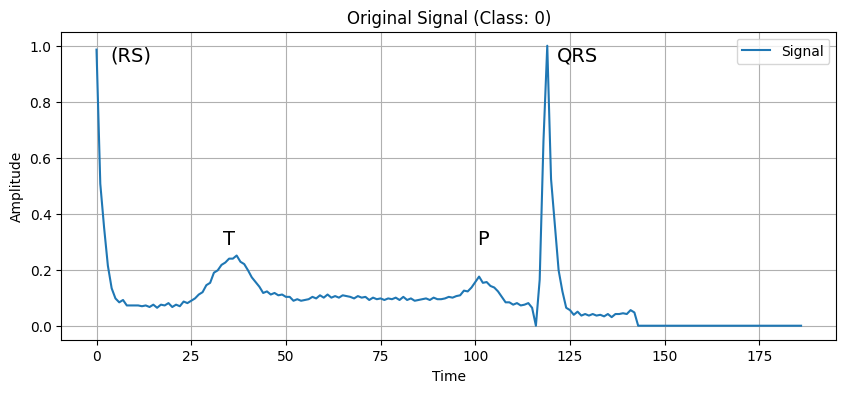

In [30]:
# Visualization of an individual signal
idx_example = 16

original_signal = mitbih_train_df.iloc[idx_example, :-1].values
class_label = mitbih_train_df.iloc[idx_example, -1]

plt.figure(figsize=(10, 4))
plt.plot(original_signal, label="Signal")
plt.title(f'Original Signal (Class: {class_label})')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)

plt.text(102, original_signal[35] + 0.05, "P", fontsize=14, color="black", ha="center")
plt.text(127, original_signal[90] + 0.85, "QRS", fontsize=14, color="black", ha="center")
plt.text(35, original_signal[35] + 0.05, "T", fontsize=14, color="black", ha="center")
plt.text(9, original_signal[90] + 0.85, "(RS)", fontsize=14, color="black", ha="center")

plt.legend()
plt.show()

#### **Example Signal Analysis**

We can see that the Signal (here as an example a normal heartbeat (Class:0)) deviates from the regular ECG signal in the following way:
- In the column with index 0, the signal starts as an annotation signal, triggered by the maximum of a QRS complex. The signal therefore begins with an incomplete QRS complex (actually only RS-Complex).
- This is followed by the T wave, which represents the regression of the excitation of the incompletely imaged QRS complex.
- If present, the P-wave then occurs.
- This is followed by a completely represented QRS-Complex. 

- <u> This means: To determine the heart rhythm (class 0-4) a T-wave is used that corresponds to a only partially represented QRS-Complex

### **The Role of Singal Granularity**

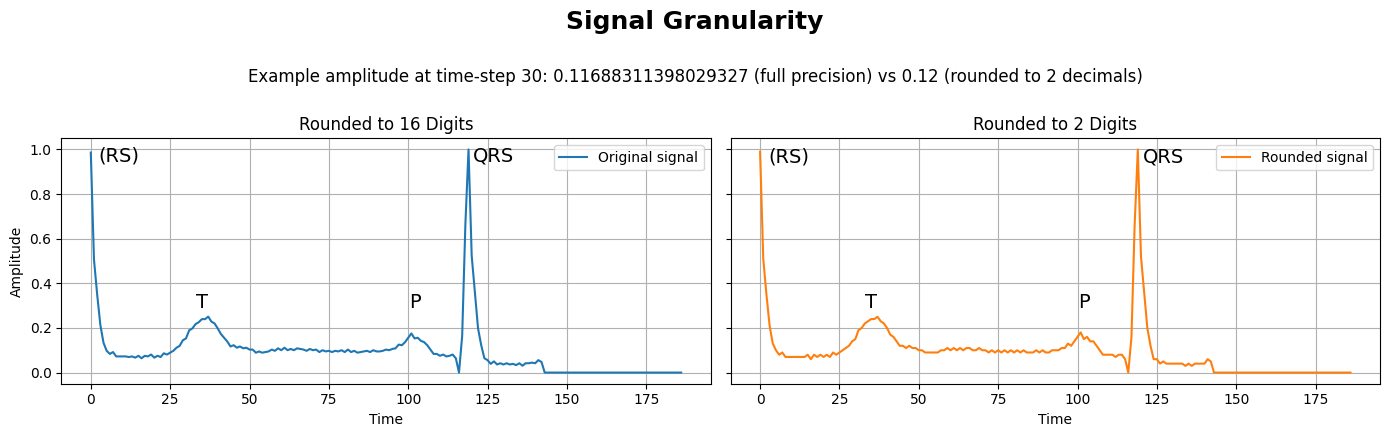

In [31]:
# Two-panel visualisation: original (≈16-digit) vs. rounded (2-digit) ECG

import numpy as np
import matplotlib.pyplot as plt

# 1) Select the sample
idx_example = 16
original_signal = mitbih_train_df.iloc[idx_example, :-1].values
class_label = int(mitbih_train_df.iloc[idx_example, -1])

# 2) Round to three decimals
rounded_signal = np.round(original_signal, decimals=2)

fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

fig.suptitle(
    "Signal Granularity",
    fontsize=18,
    fontweight="bold",
    y=1.08                           #
)
fig.text(
    0.5,
    0.9,                         
    "Example amplitude at time-step 30: 0.11688311398029327 "
    "(full precision) vs 0.12 (rounded to 2 decimals)",
    ha="center",
    fontsize=12
)

def add_annotations(ax, signal):
    """Add P, QRS, T, (RS) markers to an axis."""
    ax.text(102, signal[35] + 0.05, "P",   fontsize=14, ha="center")
    ax.text(127, signal[90] + 0.85, "QRS", fontsize=14, ha="center")
    ax.text(35,  signal[35] + 0.05, "T",   fontsize=14, ha="center")
    ax.text(9,   signal[90] + 0.85, "(RS)",fontsize=14, ha="center")

# Left panel: full precision
axes[0].plot(original_signal, label="Original signal")
axes[0].set_title("Rounded to 16 Digits")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)
add_annotations(axes[0], original_signal)
axes[0].legend()

# Right panel: rounded
axes[1].plot(rounded_signal, label="Rounded signal", color="tab:orange")
axes[1].set_title("Rounded to 2 Digits")
axes[1].set_xlabel("Time")
axes[1].grid(True)
add_annotations(axes[1], rounded_signal)
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
# fig.savefig("../visualizations/signal_granularity.png", dpi=300, bbox_inches="tight")
plt.show()


#### **Signal Granularity**
- Each of the original Signals consists of 16 decimal places
- This graph presents a sample signal, displayed once with full 16-decimal precision and once rounded to two decimal places.

- <u> Conclusion: For a physician, two decimal places are entirely sufficient to make a diagnosis

## **2. Class Distribution**

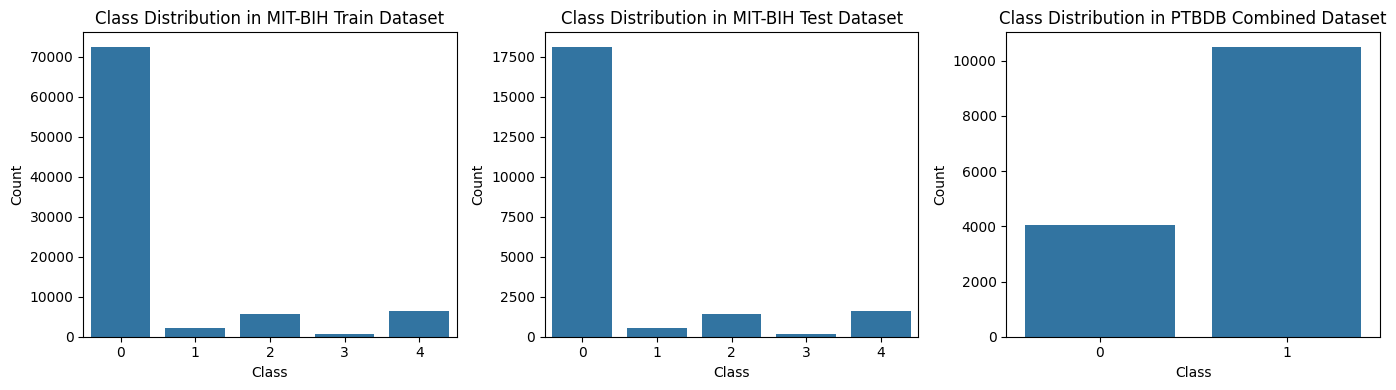

In [32]:
# Create a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Plot class distribution for MIT-BIH Train Dataset
sns.countplot(x=mitbih_train_df[188], ax=axes[0])  # use the Series directly
axes[0].set_title("Class Distribution in MIT-BIH Train Dataset")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# Plot class distribution for MIT-BIH Test Dataset
sns.countplot(x=mitbih_test_df[188], ax=axes[1])
axes[1].set_title("Class Distribution in MIT-BIH Test Dataset")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

# Plot class distribution for PTBDB Combined Dataset
sns.countplot(x=ptbdb_comb_df[188], ax=axes[2])
axes[2].set_title("Class Distribution in PTBDB Combined Dataset")
axes[2].set_xlabel("Class")
axes[2].set_ylabel("Count")

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

#### **Class Distribution Analysis**

- The three-panel chart illustrates that normal beats (class N) overwhelmingly dominate both the MIT-BIH training and test sets, while supraventricular (S), ventricular (V), fusion (F) and unclassifiable (Q) beats occur much less frequently.

- Such a pronounced class imbalance can bias any classifier toward predicting the majority class, reducing sensitivity to rarer beat types.

- In the PTBDB distribution, pathological signals (Class 1) outnumber normal signals (Class 0) by roughly 2∶1.

- Implementing data-balancing strategies is therefore advisable to prevent the model from becoming skewed toward pathological patterns.

- <u>Conclusion: For reliable performance, balancing techniques are essential to mitigate biases in both beat-type and pathology-based datasets!</u>


## **3. Correlation Matrix**

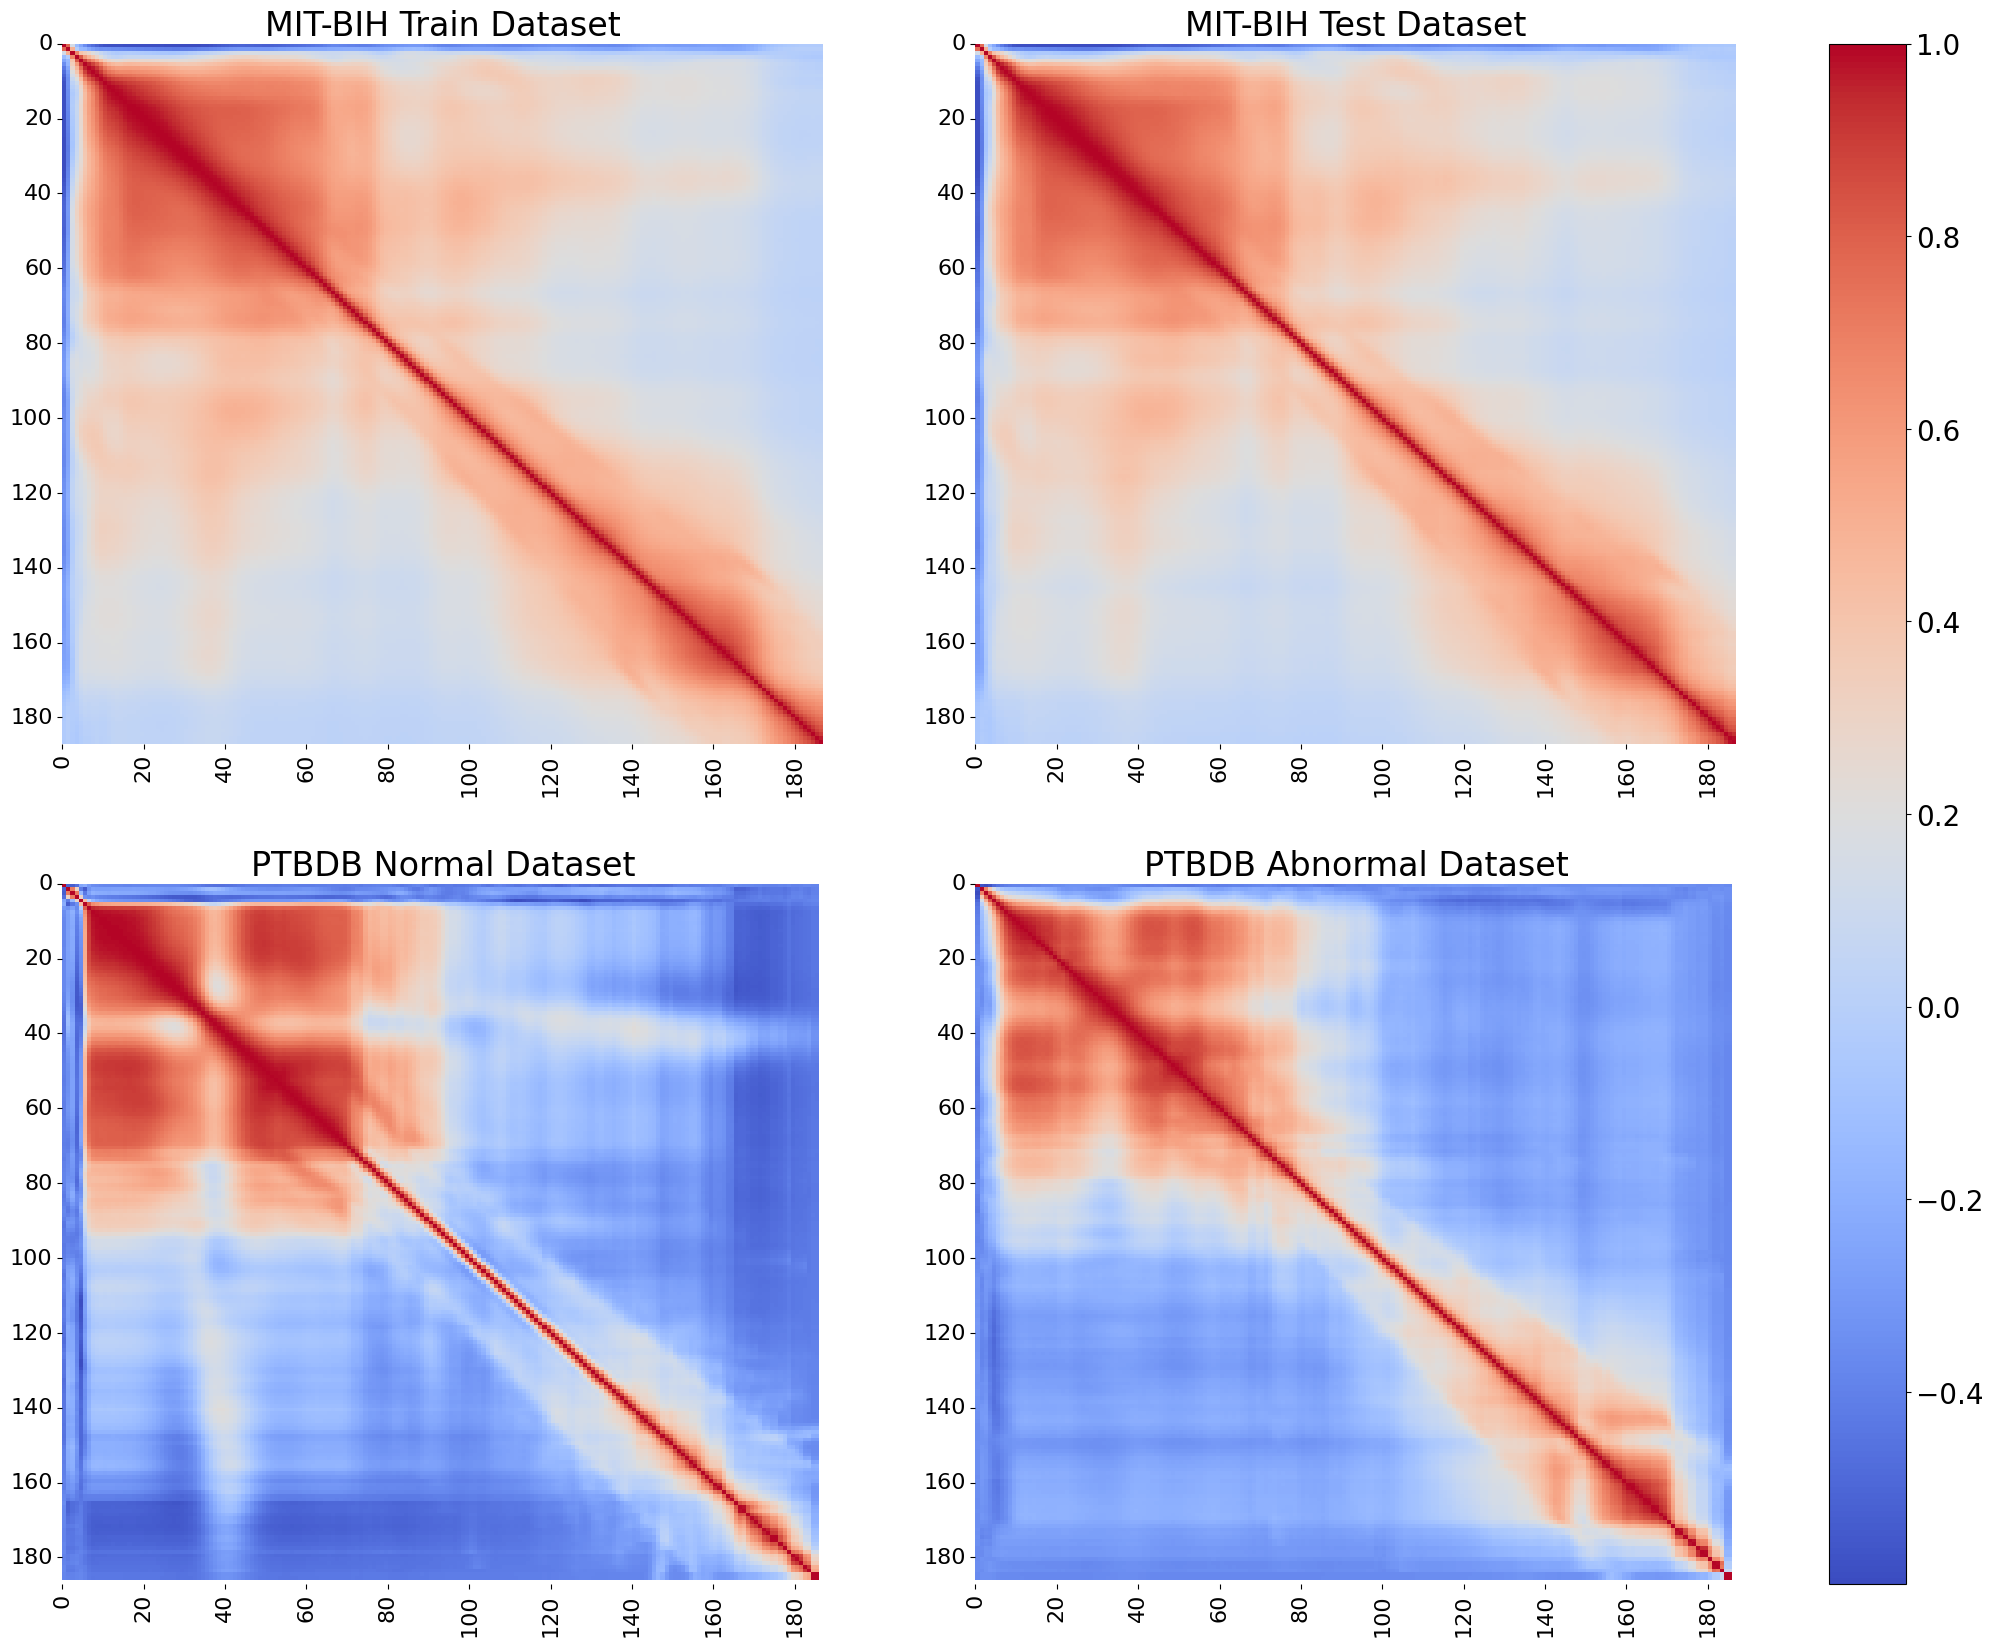

In [33]:
# Compute correlation matrices for all four subsets
corr_mitbih_train = mitbih_train_df.iloc[:, :-1].corr()
corr_mitbih_test = mitbih_test_df.iloc[:, :-1].corr()
corr_ptbdb_normal = ptbdb_normal_df.iloc[:, :-1].corr()
corr_ptbdb_abnormal = ptbdb_abnormal_df.iloc[:, :-1].corr()

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(24, 20))

# Helper function to set tick labels every 20 features
def set_ticks(ax, num_features):
    ax.set_xticks(range(0, num_features, 20))
    ax.set_xticklabels(range(0, num_features, 20), fontsize=16, rotation=90)
    ax.set_yticks(range(0, num_features, 20))
    ax.set_yticklabels(range(0, num_features, 20), fontsize=16)

# Plot MIT-BIH Train correlation matrix
sns.heatmap(corr_mitbih_train, annot=False, cmap="coolwarm", ax=axes[0, 0], cbar=False)
axes[0, 0].set_title("MIT-BIH Train Dataset", fontsize=24)
set_ticks(axes[0, 0], mitbih_train_df.shape[1] - 1)

# Plot MIT-BIH Test correlation matrix
sns.heatmap(corr_mitbih_test, annot=False, cmap="coolwarm", ax=axes[0, 1], cbar=False)
axes[0, 1].set_title("MIT-BIH Test Dataset", fontsize=24)
set_ticks(axes[0, 1], mitbih_test_df.shape[1] - 1)

# Plot PTBDB Normal correlation matrix
sns.heatmap(corr_ptbdb_normal, annot=False, cmap="coolwarm", ax=axes[1, 0], cbar=False)
axes[1, 0].set_title("PTBDB Normal Dataset", fontsize=24)
set_ticks(axes[1, 0], ptbdb_normal_df.shape[1] - 1)

# Plot PTBDB Abnormal correlation matrix
sns.heatmap(corr_ptbdb_abnormal, annot=False, cmap="coolwarm", ax=axes[1, 1], cbar=False)
axes[1, 1].set_title("PTBDB Abnormal Dataset", fontsize=24)
set_ticks(axes[1, 1], ptbdb_abnormal_df.shape[1] - 1)

# Add a single colorbar for all subplots
cbar = fig.colorbar(axes[0, 0].collections[0], ax=axes, orientation="vertical", fraction=0.05, pad=0.05)
cbar.ax.tick_params(labelsize=20)

plt.show()


#### **Correlation Analysis of ECG Signals**

- **MIT-BIH Train vs. Test**  
  Both matrices show a pronounced diagonal (high autocorrelation) and a coherent high-correlation region within the first ~60 samples, confirming that the temporal dependencies in the training set are well represented in the test set.

- **PTBDB Normal vs. Abnormal**  
  - **Normal**: Distinct high-correlation blocks at the beginning of the signal and rapidly decreasing correlation toward the end.  
  - **Abnormal**: Autocorrelation remains strong but is more diffusely distributed, with less well-defined blocks.  
  The less clear correlation structure in the PTBDB abnormal set likely reflects the heterogeneous presentations of myocardial infarction, yielding more variable ECG patterns.


## **4. Relationship between averaged and individual signal**

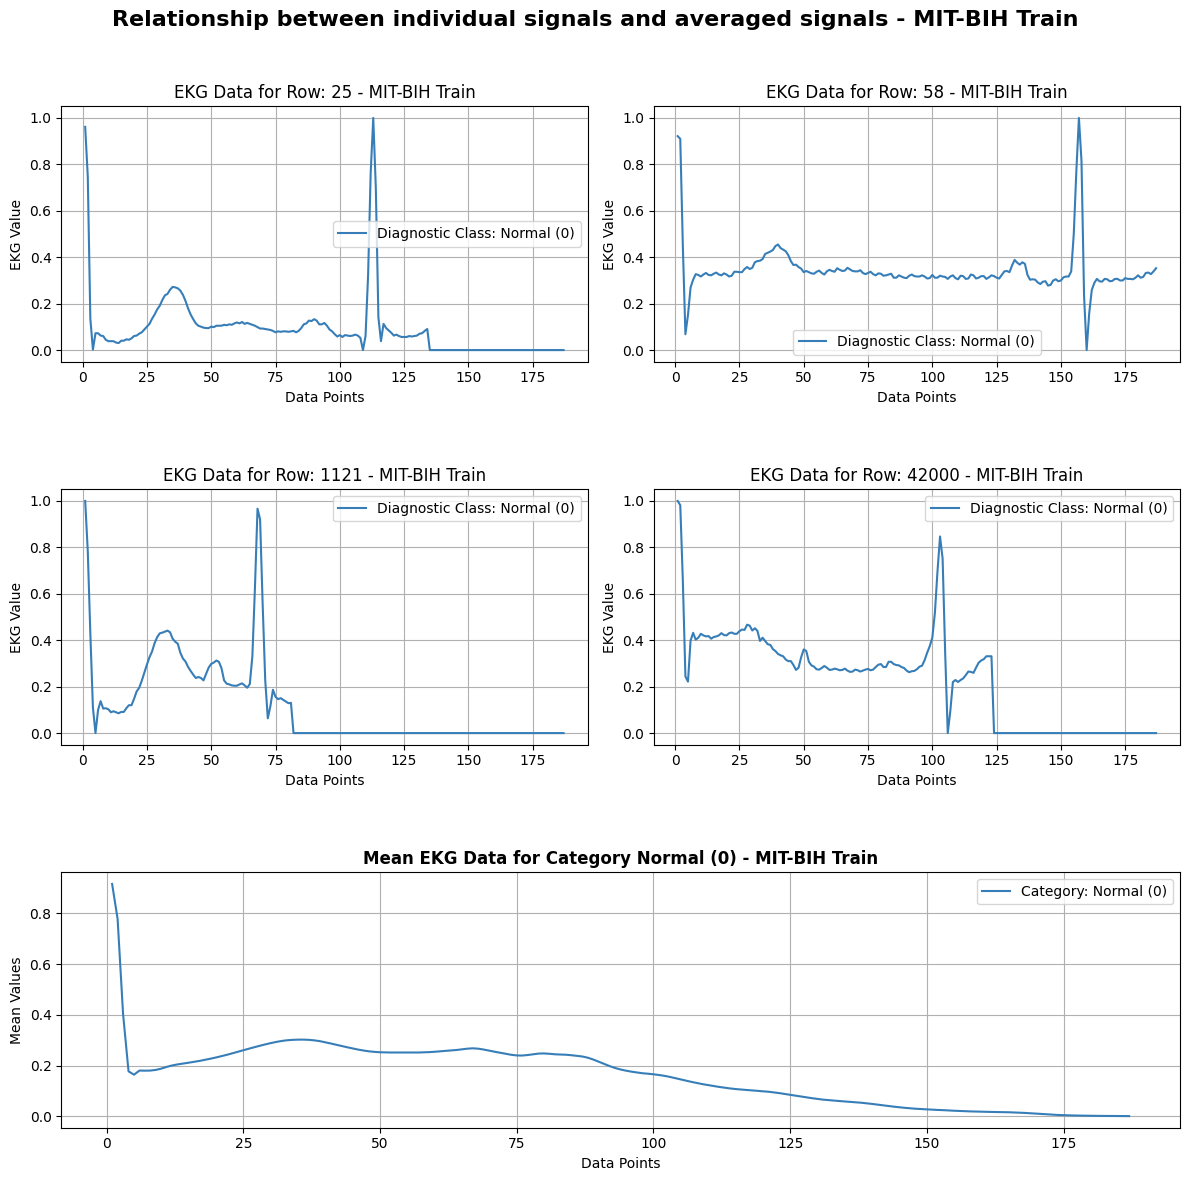

In [14]:
import matplotlib.pyplot as plt

# Updated category mapping
category_mapping = {
    0: "Normal (0)",
    1: "Supraventricular (1)",
    2: "Ventricular (2)",
    3: "Fusion-beat (3)",
    4: "Unclassified (4)"
}

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Plot 1
category_label = category_mapping[mitbih_train_df.iloc[25, 187]]
axs[0, 0].plot(range(1, 188), mitbih_train_df.iloc[25, :187], 
               label=f"Diagnostic Class: {category_label}", color='#377eb8')
axs[0, 0].set_xlabel('Data Points')
axs[0, 0].set_ylabel('EKG Value')
axs[0, 0].set_title('EKG Data for Row: 25 - MIT-BIH Train')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2
category_label = category_mapping[mitbih_train_df.iloc[58, 187]]
axs[0, 1].plot(range(1, 188), mitbih_train_df.iloc[58, :187], 
               label=f"Diagnostic Class: {category_label}", color='#377eb8')
axs[0, 1].set_xlabel('Data Points')
axs[0, 1].set_ylabel('EKG Value')
axs[0, 1].set_title('EKG Data for Row: 58 - MIT-BIH Train')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3
category_label = category_mapping[mitbih_train_df.iloc[1121, 187]]
axs[1, 0].plot(range(1, 188), mitbih_train_df.iloc[1121, :187], 
               label=f"Diagnostic Class: {category_label}", color='#377eb8')
axs[1, 0].set_xlabel('Data Points')
axs[1, 0].set_ylabel('EKG Value')
axs[1, 0].set_title('EKG Data for Row: 1121 - MIT-BIH Train')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4
category_label = category_mapping[mitbih_train_df.iloc[42000, 187]]
axs[1, 1].plot(range(1, 188), mitbih_train_df.iloc[42000, :187], 
               label=f"Diagnostic Class: {category_label}", color='#377eb8')
axs[1, 1].set_xlabel('Data Points')
axs[1, 1].set_ylabel('EKG Value')
axs[1, 1].set_title('EKG Data for Row: 42000 - MIT-BIH Train')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Displaying the Mean by category in a larger subplot spanning the entire bottom row
axs[2, 0].remove()  # Remove the subplot at position [2, 0] to merge cells
axs[2, 1].remove()  # Remove the subplot at position [2, 1] to merge cells
ax_mean = fig.add_subplot(3, 2, (5, 6))

grouped = mitbih_train_df.groupby(188)
means = grouped.mean()
category_0_mean = means.loc[0] 
ax_mean.plot(range(1, 188), category_0_mean, label='Category: Normal (0)', color='#377eb8')

ax_mean.set_xlabel('Data Points')
ax_mean.set_ylabel('Mean Values')
ax_mean.set_title('Mean EKG Data for Category Normal (0) - MIT-BIH Train', fontweight = "bold")
ax_mean.legend()
ax_mean.grid(True)

fig.suptitle('Relationship between individual signals and averaged signals - MIT-BIH Train', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=0.5)  
plt.show()

#### **Combined ECG Graph Analysis**
- The combined graphs for PTBDB (abnormal) and MIT-BIH (normal) show four random individual ECGs followed by the mean signal per class, demonstrating that these observations hold across all diagnostic categories.
- Individual traces reveal distinct P waves, QRS complexes and T waves: a data peak at columns 0–3 (incomplete QRS) marks the start, followed by a rapid drop; heart-rate variation shifts the P wave and the second (complete) QRS to different positions.
- Zero-fill segments appearing after the second QRS vary in timing due to preprocessing and do not represent true ECG data.
- In the averaged MIT-BIH normals, a high initial amplitude gradually decays, with small peaks around data points 25–40, 60 and 80; most diagnostic details are lost upon averaging.
- <u>Conclusion: Averaging preserves only the initial incomplete QRS complex and the T-wave, limiting the diagnostic value of the mean ECG signal.</u>


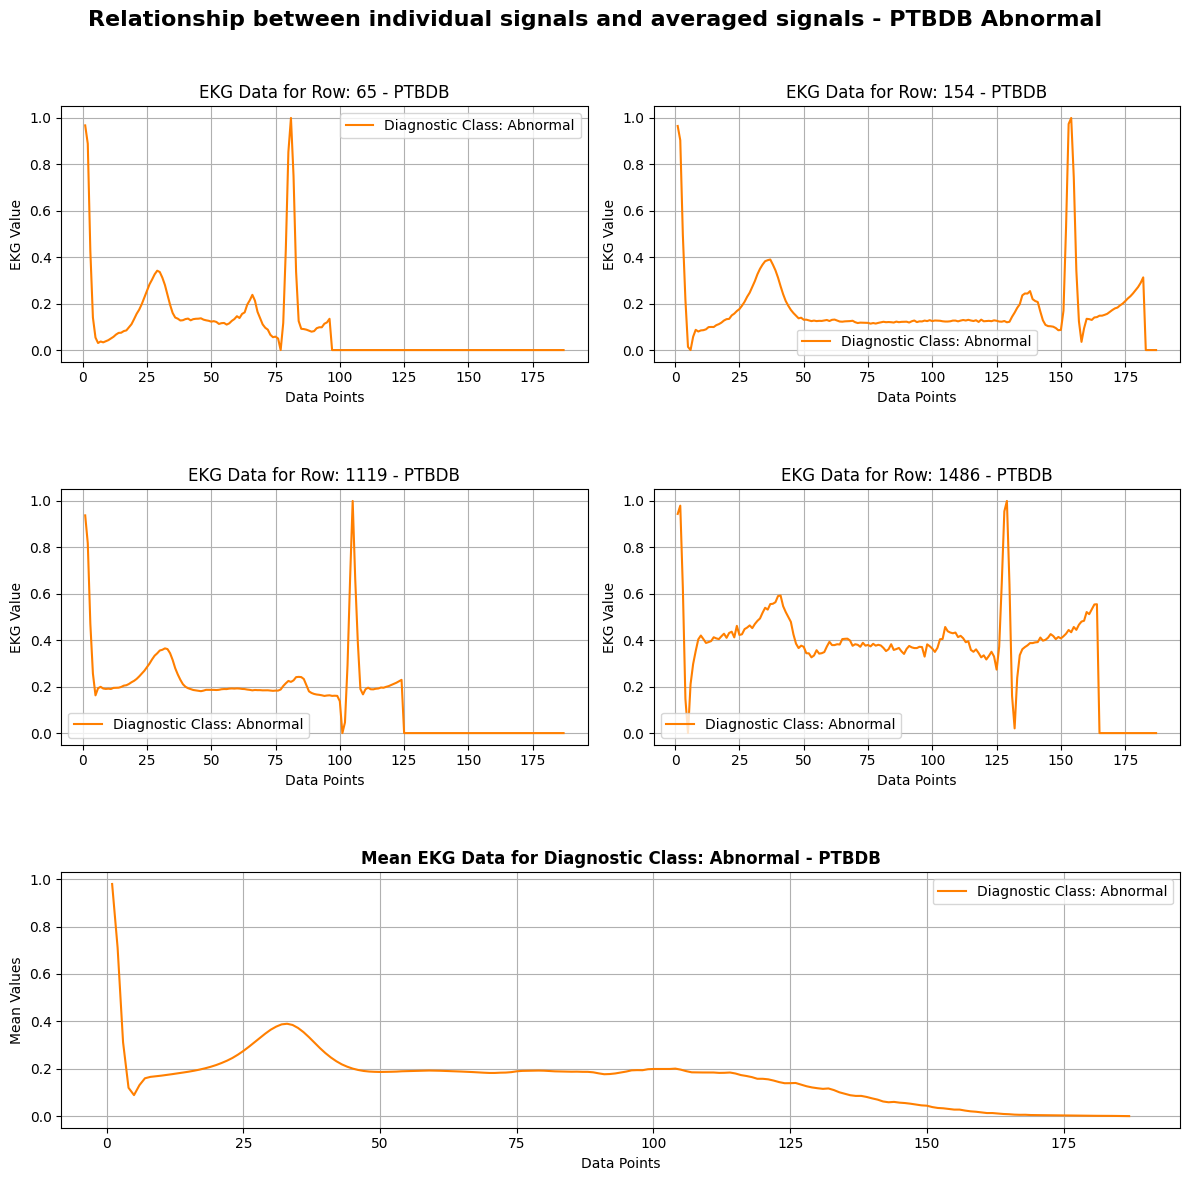

In [15]:
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628']

# Category mapping
category_mapping = {0: 'Abnormal', 1: 'Normal'}

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Plot 1: Example individual signal
axs[0, 0].plot(range(1, 188), ptbdb_comb_df.iloc[65, :187], 
               label=f'Diagnostic Class: {category_mapping[ptbdb_comb_df.iloc[65, 187]]}', color=colors[1])
axs[0, 0].set_xlabel('Data Points')
axs[0, 0].set_ylabel('EKG Value')
axs[0, 0].set_title('EKG Data for Row: 65 - PTBDB')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot 2: Example individual signal
axs[0, 1].plot(range(1, 188), ptbdb_comb_df.iloc[154, :187], 
               label=f'Diagnostic Class: {category_mapping[ptbdb_comb_df.iloc[154, 187]]}', color=colors[1])
axs[0, 1].set_xlabel('Data Points')
axs[0, 1].set_ylabel('EKG Value')
axs[0, 1].set_title('EKG Data for Row: 154 - PTBDB')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot 3: Example individual signal
axs[1, 0].plot(range(1, 188), ptbdb_comb_df.iloc[1119, :187], 
               label=f'Diagnostic Class: {category_mapping[ptbdb_comb_df.iloc[1119, 187]]}', color=colors[1])
axs[1, 0].set_xlabel('Data Points')
axs[1, 0].set_ylabel('EKG Value')
axs[1, 0].set_title('EKG Data for Row: 1119 - PTBDB')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot 4: Example individual signal
axs[1, 1].plot(range(1, 188), ptbdb_comb_df.iloc[1486, :187], 
               label=f'Diagnostic Class: {category_mapping[ptbdb_comb_df.iloc[1486, 187]]}', color=colors[1])
axs[1, 1].set_xlabel('Data Points')
axs[1, 1].set_ylabel('EKG Value')
axs[1, 1].set_title('EKG Data for Row: 1486 - PTBDB')
axs[1, 1].legend()
axs[1, 1].grid(True)

for ax in axs[2, :]:
    ax.remove() 

ax_mean = fig.add_subplot(3, 1, 3)  

grouped = ptbdb_comb_df.groupby(188)
means = grouped.mean()
category_0_mean = means.loc[0]
ax_mean.plot(range(1, 188), category_0_mean, label='Diagnostic Class: Abnormal', color=colors[1])
ax_mean.set_xlabel('Data Points')
ax_mean.set_ylabel('Mean Values')
ax_mean.set_title('Mean EKG Data for Diagnostic Class: Abnormal - PTBDB', fontweight = "bold")
ax_mean.legend()
ax_mean.grid(True)

# Add main title
fig.suptitle('Relationship between individual signals and averaged signals - PTBDB Abnormal', fontsize=16, fontweight = "bold")

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.subplots_adjust(hspace=0.5) 
plt.show()

#### **Averaged-Class Signal Analysis**

* The patterns observed in the example ECGs extend across all diagnostic classes in both the MIT-BIH and PTBDB datasets.
* The graphs below present the mean waveform for each class, highlighting class-specific trends.
* Despite distinguishable average shapes between classes, the detailed ECG morphology is lost in every averaged signal.
* <u>Conclusion: Mean signals fail to preserve key ECG features, undermining their diagnostic value across all classes</u>


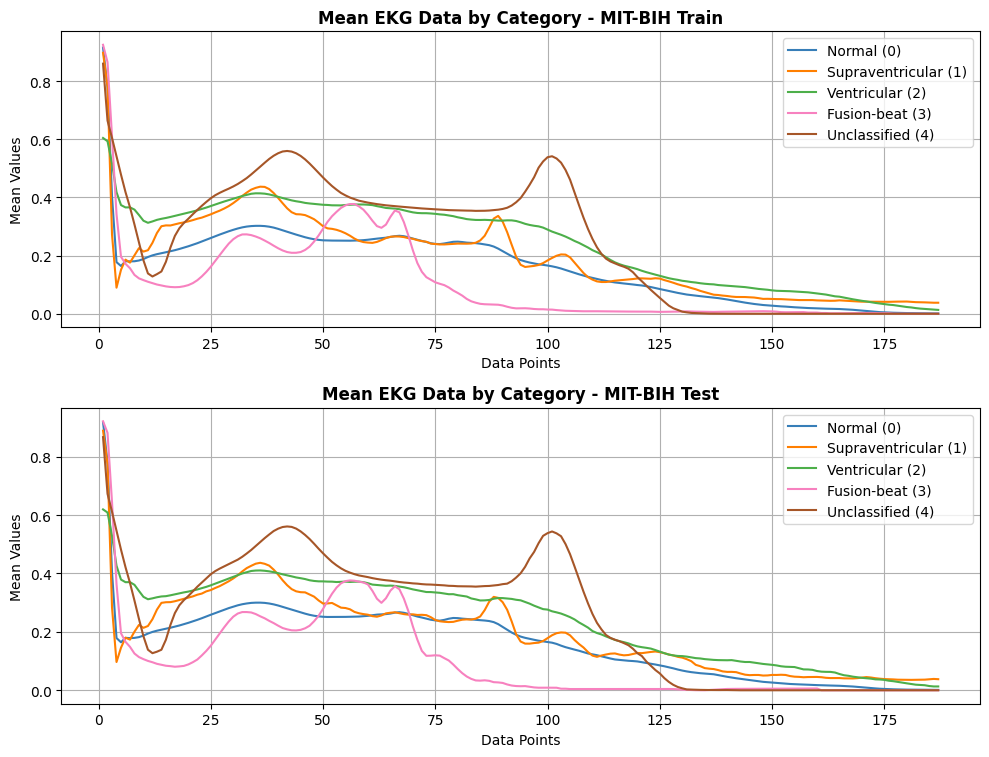

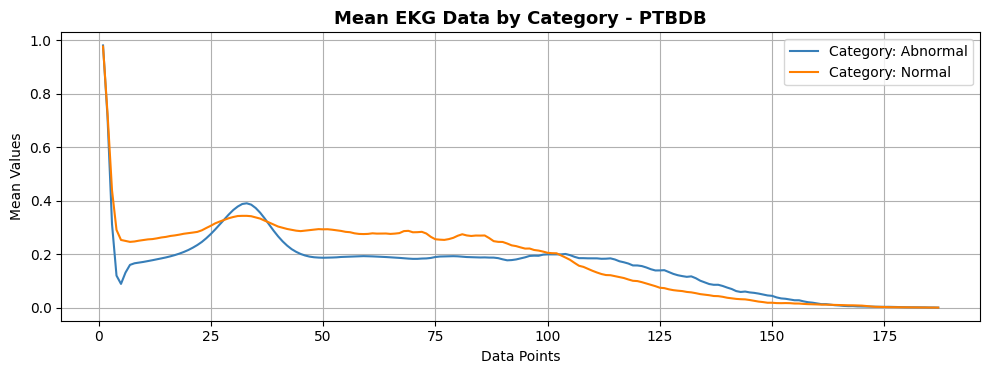

In [16]:
# MIT-BIH
categories = ["Normal", "Supraventricular", "Ventricular", "Fusion-beat", "Unclassified"]

category_mapping = {
    0: "Normal (0)",
    1: "Supraventricular (1)",
    2: "Ventricular (2)",
    3: "Fusion-beat (3)",
    4: "Unclassified (4)"
}
class_numbers = {v: k for k, v in category_mapping.items()}

colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628']

# First plot: Train Data
grouped_train = mitbih_train_df.groupby(188)
means_train = grouped_train.mean()

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
for i, category in enumerate(means_train.index):
    category_name = category_mapping[category]
    plt.plot(range(1, 188), means_train.loc[category], label=f'{category_name}', color=colors[i])
plt.xlabel('Data Points')
plt.ylabel('Mean Values')
plt.title('Mean EKG Data by Category - MIT-BIH Train', fontweight = "bold")
plt.legend()
plt.grid(True)

# Second plot: Testing data
grouped_test = mitbih_test_df.groupby(188)
means_test = grouped_test.mean()

plt.subplot(2, 1, 2)
for i, category in enumerate(means_test.index):
    category_name = category_mapping[category]
    plt.plot(range(1, 188), means_test.loc[category], label=f'{category_name}', color=colors[i])
plt.xlabel('Data Points')
plt.ylabel('Mean Values')
plt.title('Mean EKG Data by Category - MIT-BIH Test', fontweight = "bold")
plt.legend()
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('mean_ekg_data_mit_bih.png')
plt.show()

# PTBDB
grouped = ptbdb_comb_df.groupby(188)

means = grouped.mean()
colors = ['#377eb8', '#ff7f00'] 

category_mapping = {0: 'Abnormal', 1: 'Normal'}

plt.figure(figsize=(10, 4))
for i, category in enumerate(means.index):
    plt.plot(range(1, 188), means.loc[category], label=f'Category: {category_mapping[category]}', color=colors[i])
plt.xlabel('Data Points')
plt.ylabel('Mean Values')
plt.title('Mean EKG Data by Category - PTBDB', fontsize=13, fontweight = "bold")
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.legend()
plt.grid(True)
# plt.savefig('mean_data_PTBDB.png')
plt.show()


#### **Column 1 Annotation Analysis**

* A pronounced peak in column 1 is visible across all individual and averaged ECG signals.
* Column 1 serves as the annotation marker for the preceding QRS complex, with most entries set to 1.
* The lower panels display histograms of the value distribution in column 1, revealing substantial overlap between diagnostic classes.
* Such overlap indicates that column 1 alone offers limited discriminatory power.
* <u>Conclusion: Relying solely on column 1 yields low diagnostic value—incorporating additional features is essential for accurate classification.</u>


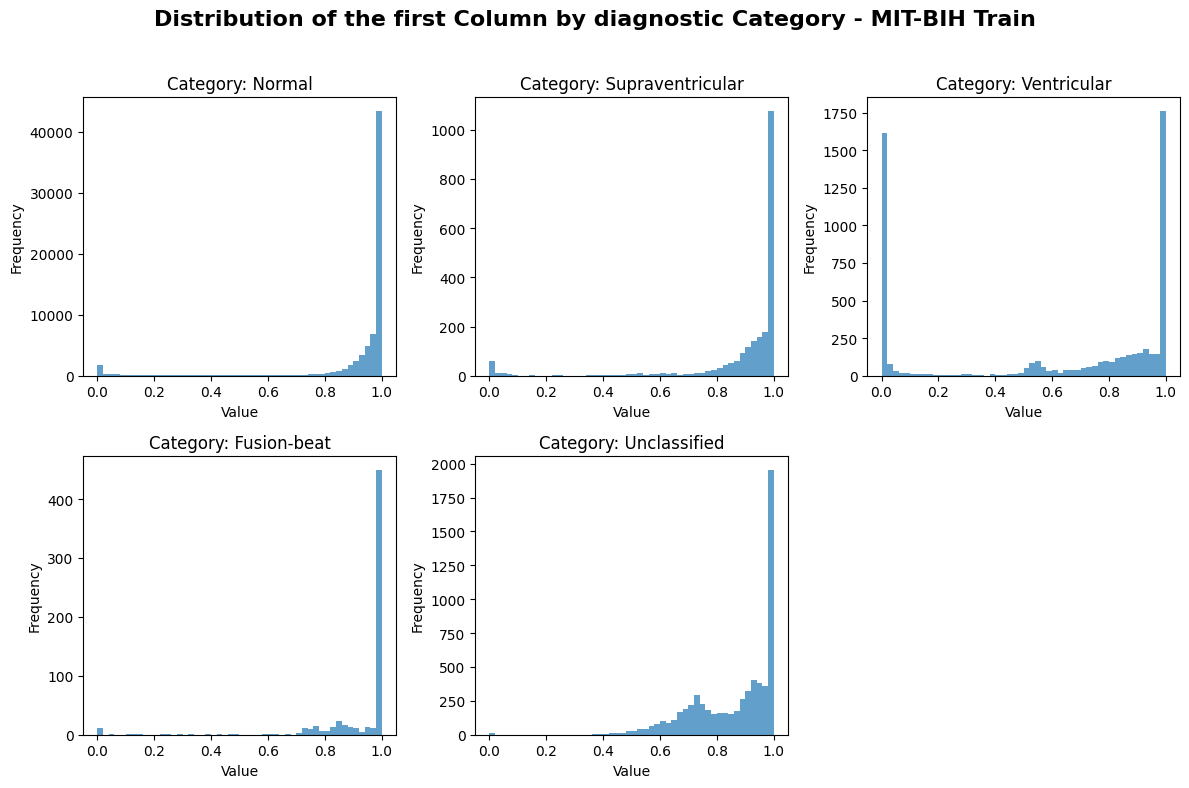

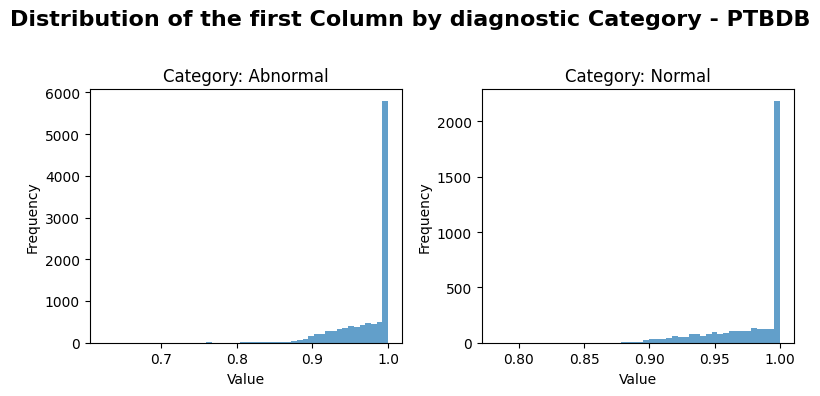

In [ ]:
# MIT-BIH

category_mapping = {
    0: "Normal",
    1: "Supraventricular",
    2: "Ventricular",
    3: "Fusion-beat",
    4: "Unclassified"
}
class_numbers = {v: k for k, v in category_mapping.items()}

plt.figure(figsize=(12, 8))

for i, category in enumerate(categories):
    plt.subplot(2, 3, i + 1)
    subset_df = mitbih_train_df[mitbih_train_df[188] == class_numbers[category]]
    plt.hist(subset_df.iloc[:, 0], bins=50, alpha=0.7, label=f'Category {category}')
    plt.title(f'Category: {category}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Distribution of the first Column by diagnostic Category - MIT-BIH Train', fontsize=16, fontweight = "bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig('MITBIH_dist_first_row.png')
plt.show()

# PTBDB
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(ptbdb_abnormal_df.iloc[:, 0], bins=50, alpha=0.7, label='Abnormal')
plt.title('Category: Abnormal')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(ptbdb_normal_df.iloc[:, 0], bins=50, alpha=0.7, label='Normal')
plt.title('Category: Normal')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle('Distribution of the first Column by diagnostic Category - PTBDB', fontsize=16, fontweight = "bold")
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
#plt.savefig('PTBDB_dist_first_row.png')
plt.show()

#### **Normality Test Analysis**

* The D’Agostino-Pearson normality test was applied to every column, separated by diagnostic class, at a significance level of α = 0.05.
* **PTBDB dataset:** 0 % of columns passed as normally distributed.
* **MIT-BIH Train dataset:** 0.21 % of columns passed as normally distributed.
* **MIT-BIH Test dataset:** 1.06 % of columns passed as normally distributed.
* These results emerged despite performing the tests within each diagnostic category, indicating that preprocessing and physiological variability prevent normality.
* The lower panel shows the value distribution and QQ-plot for a representative column—confirming that normality cannot be assumed.
* <u>Conclusion: For the vast majority of features, normal distribution may not be assumed.</u>


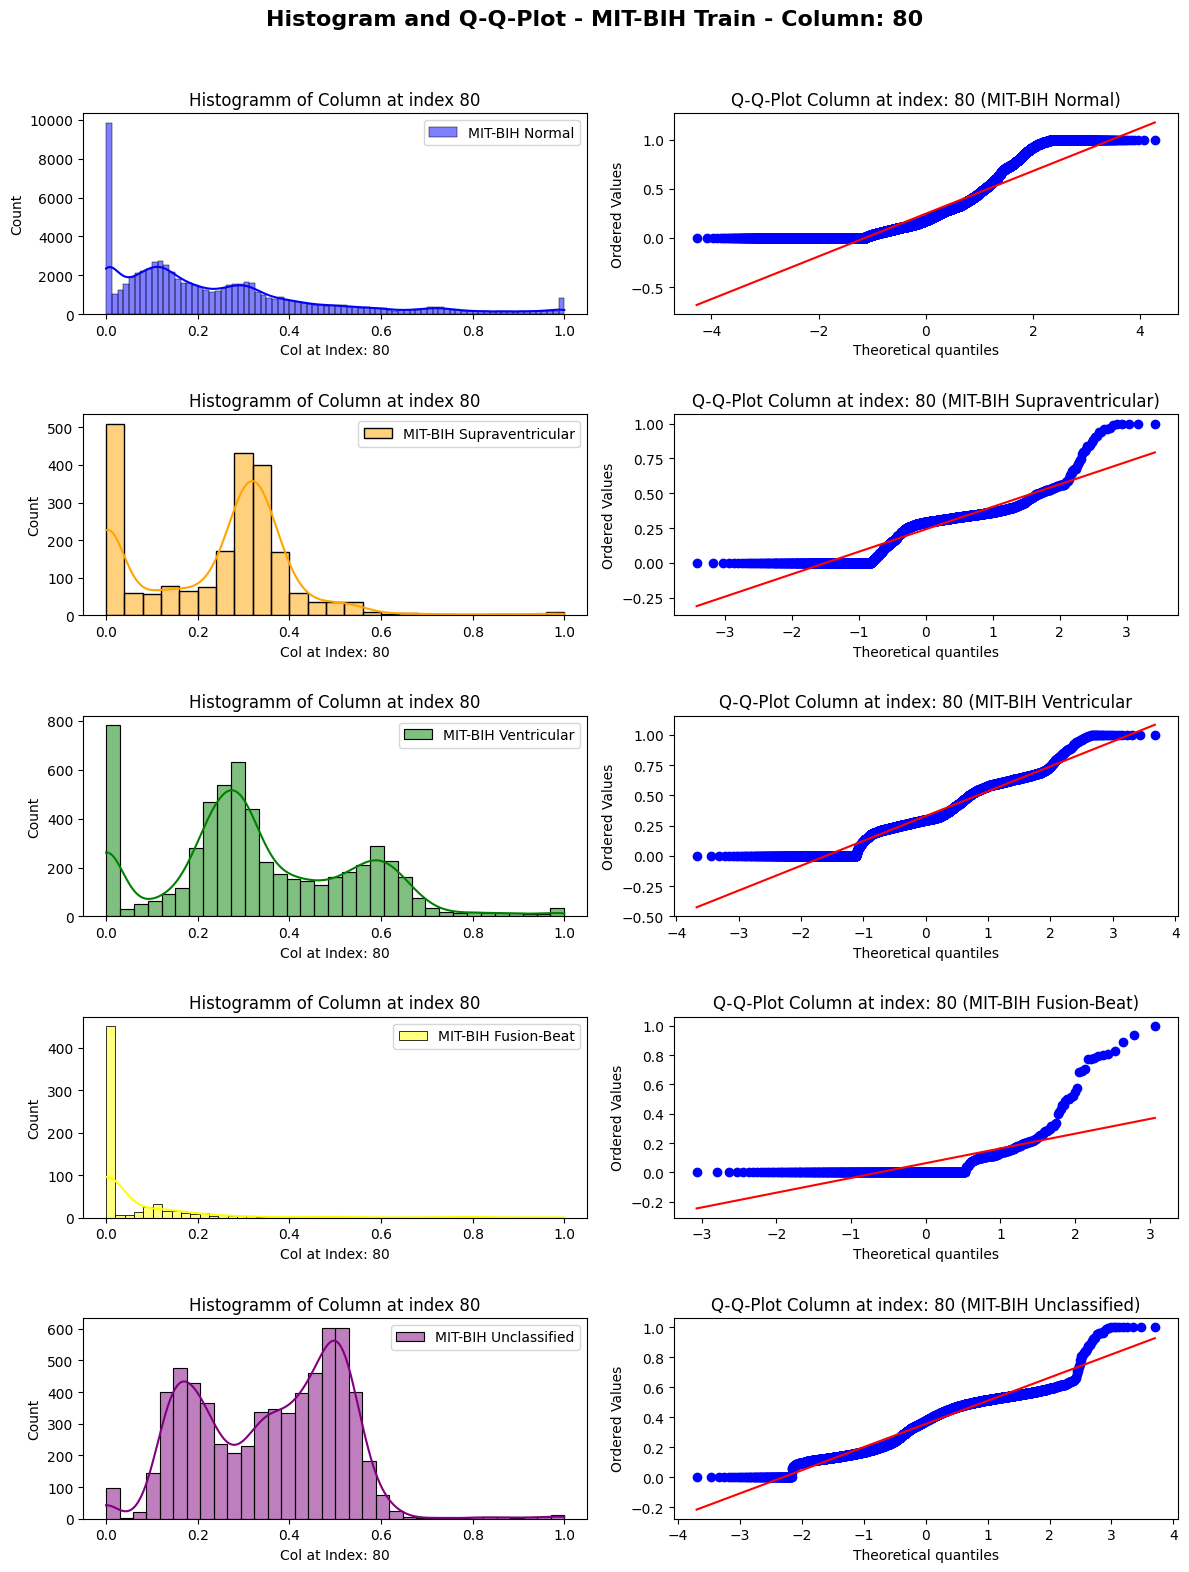

In [24]:
# Normal-Distribution of the explanatory variables? - Visual - MIT-BIH Train
# Seperated by the target variable.

# Choose Column to Check: 
column = 80

X = mitbih_train_df.iloc[:, :-1]  
y = mitbih_train_df.iloc[:, -1]   
normal = X[y == 0]
supraventricular = X[y == 1]
ventricular = X[y == 2]
fusion = X[y == 3]
unclassified = X[y == 4]

plt.figure(figsize=(12, 16))

plt.subplot(5, 2, 1)
sns.histplot(normal.iloc[:, column], kde=True, color='blue', label='MIT-BIH Normal')
plt.xlabel(f"Col at Index: {column}")
plt.legend()
plt.title(f'Histogramm of Column at index {column}')

plt.subplot(5, 2, 3)
sns.histplot(supraventricular.iloc[:, column], kde=True, color='orange', label='MIT-BIH Supraventricular')
plt.xlabel(f"Col at Index: {column}")
plt.legend()
plt.title(f'Histogramm of Column at index {column}')

plt.subplot(5, 2, 5)
sns.histplot(ventricular.iloc[:, column], kde=True, color='green', label='MIT-BIH Ventricular')
plt.xlabel(f"Col at Index: {column}")
plt.legend()
plt.title(f'Histogramm of Column at index {column}')

plt.subplot(5, 2, 7)
sns.histplot(fusion.iloc[:, column], kde=True, color='yellow', label='MIT-BIH Fusion-Beat')
plt.xlabel(f"Col at Index: {column}")
plt.legend()
plt.title(f'Histogramm of Column at index {column}')

plt.subplot(5, 2, 9)
sns.histplot(unclassified.iloc[:, column], kde=True, color='purple', label='MIT-BIH Unclassified')
plt.xlabel(f"Col at Index: {column}")
plt.legend()
plt.title(f'Histogramm of Column at index {column}')

plt.subplot(5, 2, 2)
stats.probplot(normal.iloc[:, column], dist="norm", plot=plt)
plt.title(f'Q-Q-Plot Column at index: {column} (MIT-BIH Normal)')

plt.subplot(5, 2, 4)
stats.probplot(supraventricular.iloc[:, column], dist="norm", plot=plt)
plt.title(f'Q-Q-Plot Column at index: {column} (MIT-BIH Supraventricular)')

plt.subplot(5, 2, 6)
stats.probplot(ventricular.iloc[:, column], dist="norm", plot=plt)
plt.title(f'Q-Q-Plot Column at index: {column} (MIT-BIH Ventricular')

plt.subplot(5, 2, 8)
stats.probplot(fusion.iloc[:, column], dist="norm", plot=plt)
plt.title(f'Q-Q-Plot Column at index: {column} (MIT-BIH Fusion-Beat)')

plt.subplot(5, 2, 10)
stats.probplot(unclassified.iloc[:, column], dist="norm", plot=plt)
plt.title(f'Q-Q-Plot Column at index: {column} (MIT-BIH Unclassified)')

plt.suptitle(f'Histogram and Q-Q-Plot - MIT-BIH Train - Column: {column}', fontsize=16,fontweight= "bold")

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.subplots_adjust(hspace=0.5) 
plt.show()
plt.show(); 

In [19]:
# Check for normal Distribution of the columns with D'Agostino and Pearson's Normality Test - MIT-BIH Train

from scipy.stats import normaltest

X = mitbih_train_df.iloc[:, :-1]  
y = mitbih_train_df.iloc[:, -1]   
normal = X[y == 0]
supraventricular = X[y == 1]
ventricular = X[y == 2]
fusion = X[y == 3]
unclassified = X[y == 4]

def check_normality(data, alpha=0.05):
    stat, p = normaltest(data)
    return p > alpha, stat, p

# List of categories
categories = {
    'normal': normal,
    'supraventricular': supraventricular,
    'ventricular': ventricular,
    'fusion': fusion,
    'unclassified': unclassified
}

# Perform the normality test for each column in each category and store the results
normality_results = []

for column in X.columns:
    for category_name, category_data in categories.items():
        is_normal, stat, p = check_normality(category_data[column])
        normality_results.append({
            'Variable': column,
            'Category': category_name,
            'is_normal': is_normal,
            'dagostino_stat': stat,
            'p_val': p
        })

# Convert results to DataFrame
results_df = pd.DataFrame(normality_results)

# print(results_df.head(50))

filtered_results_df = results_df[results_df['p_val'] > 0.05]

# print("Reslts of Testing for Normality (MIT-BIH Train) - Seperated by Diagnostic Category \n", results_df.head(20), "\n")
print("Number of Rows of Results: ", results_df.shape[0], "\n")
print("Filtered Reslts of Testing for Normality (MIT-BIH Train) - Rows with assumed Normal Distribution - Seperated by Diagnostic Category\n",
       filtered_results_df)

Number of Rows of Results:  935 

Filtered Reslts of Testing for Normality (MIT-BIH Train) - Rows with assumed Normal Distribution - Seperated by Diagnostic Category
      Variable      Category  is_normal  dagostino_stat     p_val
13          3        fusion       True        0.859435  0.650693
449        90  unclassified       True        4.347318  0.113761


In [20]:
# Check for normal Distribution of the columns with D'Agostino and Pearson's Normality Test - MIT-BIH Test

X = mitbih_test_df.iloc[:, :-1]  
y = mitbih_test_df.iloc[:, -1]   
normal = X[y == 0]
supraventricular = X[y == 1]
ventricular = X[y == 2]
fusion = X[y == 3]
unclassified = X[y == 4]

def check_normality(data, alpha=0.05):
    stat, p = normaltest(data)
    return p > alpha, stat, p

# List of categories
categories = {
    'normal': normal,
    'supraventricular': supraventricular,
    'ventricular': ventricular,
    'fusion': fusion,
    'unclassified': unclassified
}

# Perform the normality test for each column in each category and store the results
normality_results = []

for column in X.columns:
    for category_name, category_data in categories.items():
        is_normal, stat, p = check_normality(category_data[column])
        normality_results.append({
            'Variable': column,
            'Category': category_name,
            'is_normal': is_normal,
            'dagostino_stat': stat,
            'p_val': p
        })

# Convert results to DataFrame
results_df = pd.DataFrame(normality_results)

# print(results_df.head(50))
filtered_results_df = results_df[results_df['p_val'] > 0.05]

# print("Reslts of Testing for Normality (MIT-BIH Train) - Seperated by Diagnostic Category \n", results_df.head(20), "\n")
print("Number of Rows of Results: ", results_df.shape[0], "\n")
print("Filtered Reslts of Testing for Normality (MIT-BIH Train) - Rows with assumed Normal Distribution - Seperated by Diagnostic Category\n",
       filtered_results_df)

Number of Rows of Results:  935 

Filtered Reslts of Testing for Normality (MIT-BIH Train) - Rows with assumed Normal Distribution - Seperated by Diagnostic Category
      Variable          Category  is_normal  dagostino_stat     p_val
151        31  supraventricular       True        2.844538  0.241166
156        32  supraventricular       True        1.822854  0.401950
206        42  supraventricular       True        0.272334  0.872697
404        81      unclassified       True        2.169053  0.338062
409        82      unclassified       True        3.093586  0.212930
429        86      unclassified       True        5.393187  0.067435
439        88      unclassified       True        3.414377  0.181375
444        89      unclassified       True        0.359485  0.835485
449        90      unclassified       True        5.155887  0.075930
454        91      unclassified       True        1.928847  0.381203


In [22]:
# Test for normal distribution with D'Agostino and Pearson's Normality Test - PTBDB
X = ptbdb_comb_df.iloc[:, :-1]  
y = ptbdb_comb_df.iloc[:, -1]   
normal = X[y == 0]
abnormal = X[y == 1]


def check_normality(data, alpha=0.05):
    stat, p = normaltest(data)
    return p > alpha, stat, p

normality_results = []
for column in X.columns:
    is_normal_normal_group, stat_normal, p_normal = check_normality(normal[column])
    is_normal_abnormal_group, stat_abnormal, p_abnormal = check_normality(abnormal[column])
    normality_results.append({
        'Variable': column,
        'is_normal_normal_group': is_normal_normal_group,
        'dagostino_stat_normal': stat_normal,
        'p_val_normal': p_normal,
        'is_normal_abnormal_group': is_normal_abnormal_group,
        'dagostino_stat_abnormal': stat_abnormal,
        'p_val_abnormal': p_abnormal
    })

results_df = pd.DataFrame(normality_results)

# Sort results if needed:
# sorted_results_df = results_df.sort_values(by='p_val_normal')

# Data filtering to identify variables:
filtered_results_df = results_df[
    (results_df['is_normal_normal_group'] == True) &
    (results_df['is_normal_abnormal_group'] == True)]

filtered_results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Variable                  0 non-null      int64  
 1   is_normal_normal_group    0 non-null      bool   
 2   dagostino_stat_normal     0 non-null      float64
 3   p_val_normal              0 non-null      float64
 4   is_normal_abnormal_group  0 non-null      bool   
 5   dagostino_stat_abnormal   0 non-null      float64
 6   p_val_abnormal            0 non-null      float64
dtypes: bool(2), float64(4), int64(1)
memory usage: 0.0 bytes


### **Summary – Relationship between Averaged and Individual Signals**

* **First**, alignment on the incomplete RS-wave and heart-rate-dependent shifts of P-, QRS- and T-waves cause the class-wise mean to lose critical ECG morphology present in individual traces.
* **Second**, preprocessing artifacts—annotation spikes in column 1, post-QRS zero-fills and baseline shifts—further distort the averaged waveform away from true physiological signals.
* <u>Conclusion: These findings motivate the design of advanced preprocessing pipelines that preserve essential ECG features and thus enhance model interpretability.</u>
